# Introduction

In this notebook we demonstrate the use of LSI (Latent Semantic Indexing) Information Retrieval technique to make trace link recovery between Use Cases and Bug Reports.

We model our study as follows:

* Each bug report title, summary and description compose a single query.
* We use each use case content as an entire document that must be returned to the query made

## Import Libraries

In [2]:
import pandas as pd
import numpy as np

import matplotlib.pyplot as plt

from sklearn.metrics import precision_recall_fscore_support
from scipy.sparse import csr_matrix

## Load Dataset and Preprocessing

In [90]:
trace_df = pd.read_csv('../data/jEdit/jEditDataset/oracle/output/trace_matrix.csv')
#trace_df.head()
#trace_df.shape

artfs_desc_df = pd.read_csv('../data/jEdit/jEditDataset/oracle/output/artifacts_descriptions.csv', sep="|")
#artfs_desc_df.head(50)
#artfs_desc_df.shape

use_cases_df = artfs_desc_df[artfs_desc_df.artf_description.str.contains('Use Case ID')]
#use_cases_df.head()

bug_reports_df = artfs_desc_df[artfs_desc_df.artf_description.str.contains('Bug Number')]
#bug_reports_df.head()

## Vectorize Corpus

In [9]:
from sklearn.feature_extraction.text import TfidfVectorizer
from nltk.tokenize import RegexpTokenizer
from nltk.stem import LancasterStemmer

class Tokenizer(object):
    def __init__(self):
        self.tok = RegexpTokenizer(r'some_regular_expression')
        self.stemmer = LancasterStemmer()
    
    def __call__(self, doc):
        return [self.stemmer.stem(token) 
                for token in self.tok.tokenize(doc)]

vectorizer = TfidfVectorizer(stop_words='english',
                         use_idf=True, 
                         smooth_idf=True)

## SVD Transformation 

In [10]:
from sklearn.decomposition import TruncatedSVD

svd_model = TruncatedSVD(n_components = 100, 
                         algorithm = 'randomized',
                         n_iter = 10, 
                         random_state = 42)

## Pipeline

In [11]:
from sklearn.pipeline import Pipeline

corpus = use_cases_df.artf_description

svd_transformer = Pipeline([('tfidf', vectorizer), 
                            ('svd', svd_model)])

svd_matrix = svd_transformer.fit_transform(corpus)

## Vectorize Query Corpus

In [12]:
query = bug_reports_df.artf_description
query_vector = svd_transformer.transform(query)

### Calculate Distance Matrix

In [13]:
from sklearn.metrics import pairwise_distances

distance_matrix = pairwise_distances(query_vector, 
                                     svd_matrix, 
                                     metric='cosine', 
                                     n_jobs=-1)

print(distance_matrix)

[[0.76183964 0.7871869  0.72662206 0.47823843 0.34470983 0.52026444
  0.18138903 0.39168294 0.92719236 0.91594131]
 [0.68498706 0.79615296 0.93980893 0.60134476 0.11905584 0.48900347
  0.23374624 1.         0.87580531 0.94693116]
 [0.92158677 0.86154235 0.10214744 1.         1.         1.
  1.         1.         0.89832965 0.84830335]
 [1.         1.         1.         1.         1.         1.
  1.         0.07083447 1.         1.        ]
 [0.91314687 0.95532915 0.80962194 0.69499955 0.80347947 0.75192453
  0.76485122 0.07337884 1.         0.83214881]
 [0.33601348 0.28351503 0.43341649 0.35670147 0.48119098 0.33466231
  0.30161511 0.50176853 0.28256427 0.50045862]
 [0.6844322  0.82088593 0.92032059 0.47227033 0.24144784 0.39040097
  0.07710424 0.58717574 0.80271307 0.92974882]
 [0.72258799 0.84314836 0.95127178 0.24766047 0.59842502 0.25274634
  0.45942748 0.95000868 0.95680856 0.95703764]
 [0.9869092  0.99406217 0.93467474 0.9790062  0.96036463 0.96702478
  0.95055273 0.91788645 0.99

## Recovering Rank of Documents

In [14]:
def create_trace_results_df():
    trace_results_df = pd.DataFrame(use_cases_df.artf_name)

    bug_reports_list = bug_reports_df.artf_name

    for i in range(0, len(list(distance_matrix))):
        trace_results_df[bug_reports_list[i]] = distance_matrix[i]

    trace_results_df.head(20)
    
    return trace_results_df

In [15]:
trace_results_df = create_trace_results_df()

cols = trace_results_df.columns.delete(0)  # artf_name
artf_names = trace_results_df.artf_name

In [16]:
def recover_trace_links_df(threshold):
    aux_df = trace_results_df.copy()
    aux_df.set_index('artf_name', inplace=True)
    
    amount_target_docs = use_cases_df.shape[0]
    
    for col in cols:
        nlargest_df = trace_results_df.nlargest(n = int(threshold * amount_target_docs), columns=col, keep='first')    
        aux_df[col] = [1 if x in nlargest_df[col].tolist() else 0 for x in aux_df[col]]

    return aux_df

## Evaluate Recovering Efficiency

In order to evaluate the efficiency of the algorithm tested (LSI), we use common metrics applied in the field of IR:

    * Precision
    * Recall
    * F1-score

### Matrices Transformations

First, we need to make that the **oracle traces matrix** and **recovered traces matrix** have the same format:

In [17]:
def load_oracle():
    oracle_trace_df = pd.DataFrame(columns=cols)
    oracle_trace_df.insert(0, 'artf_name', list(artf_names))
    
    for index, row in trace_df.iterrows():
        idx = oracle_trace_df[oracle_trace_df.artf_name == row['trg_artf']].index
        oracle_trace_df.at[idx, row['src_artf']] = row['link']
    
    oracle_trace_df.set_index('artf_name', inplace=True)
    
    #oracle_trace_df.head(20)
    return oracle_trace_df

### Create Evaluation Dataframe

In [18]:
def evaluate_model(oracle_df, recovered_df):
    y_true = csr_matrix(oracle_df.values, dtype=int)
    y_pred = csr_matrix(recovered_df.values, dtype=int)

    p, r, f, sp = precision_recall_fscore_support(y_true, y_pred)

    eval_df = pd.DataFrame(columns=['precision','recall','fscore'])

    i = 0
    for idx, row in oracle_trace_df.iteritems():
        eval_df.at[idx, 'precision'] = p[i]
        eval_df.at[idx, 'recall'] = r[i]
        eval_df.at[idx, 'fscore'] = f[i]
        i += 1

    mean_precision_lsi = eval_df.precision.mean()
    mean_recall_lsi = eval_df.recall.mean()
    mean_fscore_lsi = eval_df.fscore.mean()
    
    return (mean_precision_lsi, mean_recall_lsi, mean_fscore_lsi)



### Precision vs Recall Curve

In [19]:
def frange(x, y, jump):
  while x < y:
    yield x
    x += jump

In [20]:
oracle_trace_df = load_oracle()
oracle_trace_df.head(20)

,BR_4020_SRC,BR_3890_SRC,BR_3844_SRC,BR_4065_SRC,BR_3880_SRC,BR_3987_SRC,BR_4067_SRC,BR_3973_SRC,BR_3898_SRC,BR_3908_SRC,BR_4058_SRC,BR_4018_SRC,BR_4005_SRC,BR_3974_SRC
artf_name,,,,,,,,,,,,,,
UC_003_TRG,0,0,0,0,0,0,0,0,0,0,0,0,0,0
UC_007_TRG,0,0,0,0,0,0,0,0,0,0,1,0,0,0
UC_010_TRG,0,0,1,0,0,0,0,0,0,0,0,0,0,0
UC_002_TRG,0,0,0,0,1,0,0,1,0,0,0,0,0,0
UC_006_TRG,1,1,0,1,1,0,0,0,0,0,0,1,0,1
UC_004_TRG,0,0,0,0,0,1,0,0,0,0,0,0,0,0
UC_005_TRG,1,1,0,0,1,0,1,0,0,0,0,1,0,0
UC_008_TRG,0,0,0,0,0,0,0,0,0,0,0,0,1,0
UC_001_TRG,0,0,0,0,0,0,0,0,0,0,0,0,0,0


In [21]:
import decimal

thresholds_values = [x for x in frange(0, 1, decimal.Decimal('0.05'))]  # thresholds are percentages

evaluations_df = pd.DataFrame(columns=['threshold','mean_precision','mean_recall','mean_fscore'])

for threshold in thresholds_values:
    recovered_trace_matrix_df = recover_trace_links_df(threshold)
    mp, mr, mfs = evaluate_model(oracle_trace_df, recovered_trace_matrix_df)
    
    evaluations_df = evaluations_df.append({'threshold':threshold,'mean_precision':mp, 'mean_recall':mr, 'mean_fscore':mfs}, ignore_index=True)

evaluations_df.head(20)

/home/guilherme/anaconda3/envs/trace-link-recovery-study/lib/python3.6/site-packages/sklearn/metrics/classification.py:1135: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples.
  'precision', 'predicted', average, warn_for)


,threshold,mean_precision,mean_recall,mean_fscore
0,0,0.000000,0.000000,0.000000
1,0.05,0.000000,0.000000,0.000000
2,0.10,0.007143,0.071429,0.012987
3,0.15,0.007143,0.071429,0.012987
4,0.20,0.007143,0.071429,0.012987
5,0.25,0.007143,0.071429,0.012987
6,0.30,0.021429,0.142857,0.036797
7,0.35,0.021429,0.142857,0.036797
8,0.40,0.021429,0.142857,0.036797
9,0.45,0.021429,0.142857,0.036797


## Draw Precision vs Recall Curve

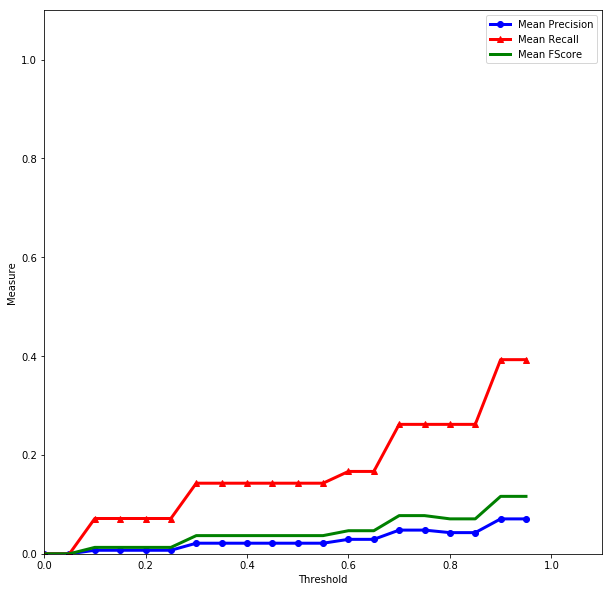

In [22]:

plt.figure(figsize=(10,10))

plt.plot(evaluations_df.threshold, evaluations_df.mean_precision, 'bo', linewidth=3.0, linestyle='-', label='Mean Precision')
plt.plot(evaluations_df.threshold, evaluations_df.mean_recall, 'r^', linewidth=3.0, linestyle='-', label='Mean Recall')
plt.plot(evaluations_df.threshold, evaluations_df.mean_fscore, 'g--', linewidth=3.0, linestyle='-', label='Mean FScore')

plt.ylabel('Measure')
plt.xlabel('Threshold')

plt.ylim(0, 1.1, 0.1)
plt.xlim(0, 1.1, 0.1)

plt.legend()

plt.show()

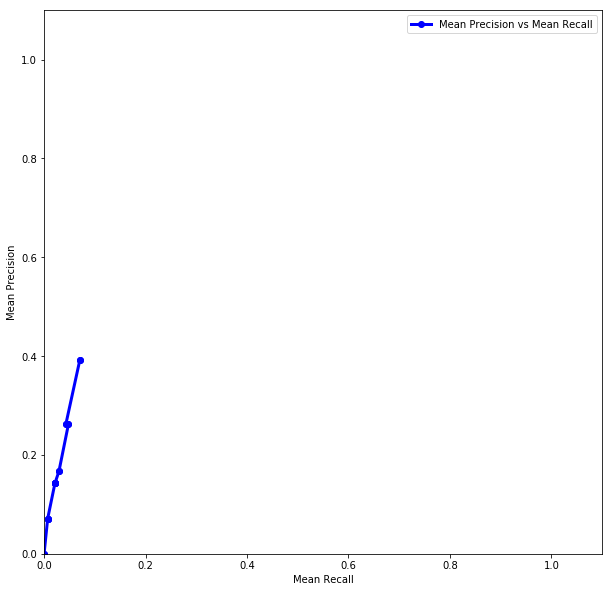

In [23]:

plt.figure(figsize=(10,10))

plt.plot(evaluations_df.mean_precision, evaluations_df.mean_recall, 'bo', linewidth=3.0, linestyle='-', label='Mean Precision vs Mean Recall')

plt.ylabel('Mean Precision')
plt.xlabel('Mean Recall')

plt.ylim(0, 1.1, 0.1)
plt.xlim(0, 1.1, 0.1)

plt.legend()

plt.show()

## Using GridSearch and Pipelines

In [88]:
from sklearn.pipeline import Pipeline
from sklearn.metrics import precision_score, recall_score, pairwise_distances, classification_report, confusion_matrix
from sklearn.externals import joblib
from sklearn.decomposition import TruncatedSVD
from sklearn.feature_extraction.text import TfidfVectorizer


class LSI:
    def __init__(self):
        self.name = "LSI"
        
        self.vectorizer = TfidfVectorizer(stop_words='english',
                                             use_idf=True, 
                                             smooth_idf=True)
        
        self.svd_model = TruncatedSVD(n_components = 100, 
                                         algorithm = 'randomized',
                                         n_iter = 10, 
                                         random_state = 42)
        self.trace_links_df = None          
    
    def recover_links(self, corpus, query, use_cases_names, bug_reports_names):
        svd_transformer = Pipeline([('tfidf', self.vectorizer), 
                            ('svd', self.svd_model)])

        svd_matrix = svd_transformer.fit_transform(corpus)
        query_vector = svd_transformer.transform(query)
        
        distance_matrix = pairwise_distances(query_vector, 
                                     svd_matrix, 
                                     metric='cosine', 
                                     n_jobs=-1)
        
        trace_results_df = pd.DataFrame(use_cases_names)
        bug_reports_list = bug_reports_names

        for i in range(0, len(list(distance_matrix))):
            trace_results_df[bug_reports_list[i]] = distance_matrix[i]
        
        self.trace_links_df = trace_results_df.copy()
        self.trace_links_df.set_index('artf_name', inplace=True)

        amount_target_docs = use_cases_df.shape[0]
        
        threshold = 3
        
        for col in cols:
            """ return top threshold documents"""
            nlargest_df = trace_results_df.nlargest(n = threshold, columns=col, keep='first')    
            self.trace_links_df[col] = [1 if x in nlargest_df[col].tolist() else 0 for x in self.trace_links_df[col]]


class OracleLoader:
    def __init__(self):
        self.oracle = None
    
    def load(self):
        self.oracle = pd.DataFrame(columns=cols)
        self.oracle.insert(0, 'artf_name', list(artf_names))

        for index, row in trace_df.iterrows():
            idx = self.oracle[self.oracle.artf_name == row['trg_artf']].index
            self.oracle.at[idx, row['src_artf']] = row['link']

        self.oracle.set_index('artf_name', inplace=True)

        
class ModelEvaluator:
    def __init__(self, scores, oracle, model):
        self.model_name = model.name
        self.scores_list = scores
        self.oracle = oracle
        self.recovered_links = model.trace_links_df
        
        self.eval_df = pd.DataFrame(columns=['precision','recall','fscore','support'])
    
    def evaluate_model(self):
        y_true = csr_matrix(self.oracle.values, dtype=int)
        y_pred = csr_matrix(self.recovered_links.values, dtype=int)
        
        p, r, f, sp = precision_recall_fscore_support(y_true, y_pred)

        i = 0
        for idx, row in oracle_trace_df.iteritems():
            self.eval_df.at[idx, 'precision'] = p[i]
            self.eval_df.at[idx, 'recall'] = r[i]
            self.eval_df.at[idx, 'fscore'] = f[i]
            self.eval_df.at[idx, 'support'] = sp[i]
            i += 1

    def print_report(self):
        mean_precision = self.eval_df.precision.mean()
        mean_recall = self.eval_df.recall.mean()
        mean_fscore = self.eval_df.fscore.mean()
        
        print("Mean Precision of {}: {:2.3}".format(self.model_name, mean_precision))
        print("Mean Recall of {}: {:2.3}".format(self.model_name, mean_recall))
        print("Mean F-Score of {}: {:2.3}".format(self.model_name, mean_fscore))
        
    def plot_precision_vs_recall(self):
        plt.figure(figsize=(10,10))
        plt.plot(self.eval_df.precision, self.eval_df.recall, 'ro', label='Precision vs Recall')

        plt.ylabel('Precision')
        plt.xlabel('Recall')

        plt.axis([0, 1.1, 0, 1.1])
        plt.legend()
        plt.show()

Mean Precision of LSI: 0.0706
Mean Recall of LSI: 0.393
Mean F-Score of LSI: 0.116


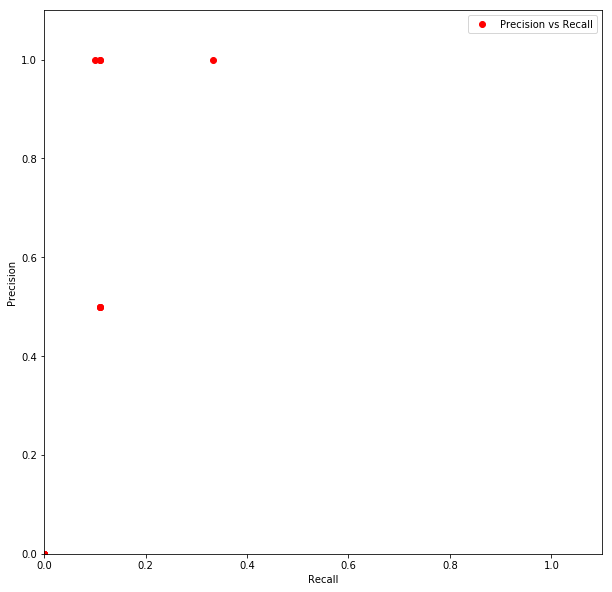

In [89]:
corpus = use_cases_df.artf_description
query = bug_reports_df.artf_description

use_cases_names = use_cases_df.artf_name
bug_reports_names = bug_reports_df.artf_name

lsi_model = LSI()
lsi_model.recover_links(corpus, query, use_cases_names, bug_reports_names)

orc = OracleLoader()
orc.load()

evaluator = ModelEvaluator([], orc.oracle, lsi_model)
evaluator.evaluate_model()
evaluator.print_report()
evaluator.plot_precision_vs_recall()

In [43]:
evaluator.recovered_links

,BR_4020_SRC,BR_3890_SRC,BR_3844_SRC,BR_4065_SRC,BR_3880_SRC,BR_3987_SRC,BR_4067_SRC,BR_3973_SRC,BR_3898_SRC,BR_3908_SRC,BR_4058_SRC,BR_4018_SRC,BR_4005_SRC,BR_3974_SRC
artf_name,,,,,,,,,,,,,,
UC_003_TRG,0,0,0,0,1,0,0,0,1,1,0,0,0,1
UC_007_TRG,1,0,0,1,1,0,1,0,1,1,0,1,1,1
UC_010_TRG,0,1,0,0,0,0,1,1,0,0,0,1,0,1
UC_002_TRG,0,0,1,1,0,0,0,0,0,0,0,0,1,1
UC_006_TRG,0,0,1,1,0,1,0,0,0,0,0,0,0,1
UC_004_TRG,0,0,0,0,0,0,0,0,0,0,0,0,0,1
UC_005_TRG,0,0,1,1,0,0,0,0,0,0,0,0,0,1
UC_008_TRG,0,1,0,0,0,1,0,0,0,0,1,0,0,1
UC_001_TRG,1,0,0,0,1,0,0,1,1,1,1,0,0,1


In [42]:
lb = preprocessing.LabelBinarizer()
lb.fit_transform(evaluator.recovered_links)

array([[0, 0, 0, 0, 1, 0, 0, 0, 1, 1, 0, 0, 0, 1],
       [1, 0, 0, 1, 1, 0, 1, 0, 1, 1, 0, 1, 1, 1],
       [0, 1, 0, 0, 0, 0, 1, 1, 0, 0, 0, 1, 0, 1],
       [0, 0, 1, 1, 0, 0, 0, 0, 0, 0, 0, 0, 1, 1],
       [0, 0, 1, 1, 0, 1, 0, 0, 0, 0, 0, 0, 0, 1],
       [0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1],
       [0, 0, 1, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1],
       [0, 1, 0, 0, 0, 1, 0, 0, 0, 0, 1, 0, 0, 1],
       [1, 0, 0, 0, 1, 0, 0, 1, 1, 1, 1, 0, 0, 1],
       [1, 1, 0, 1, 0, 1, 1, 1, 0, 0, 1, 1, 1, 1]], dtype=int64)

In [30]:
evaluator.oracle

,BR_4020_SRC,BR_3890_SRC,BR_3844_SRC,BR_4065_SRC,BR_3880_SRC,BR_3987_SRC,BR_4067_SRC,BR_3973_SRC,BR_3898_SRC,BR_3908_SRC,BR_4058_SRC,BR_4018_SRC,BR_4005_SRC,BR_3974_SRC
artf_name,,,,,,,,,,,,,,
UC_003_TRG,0,0,0,0,0,0,0,0,0,0,0,0,0,0
UC_007_TRG,0,0,0,0,0,0,0,0,0,0,1,0,0,0
UC_010_TRG,0,0,1,0,0,0,0,0,0,0,0,0,0,0
UC_002_TRG,0,0,0,0,1,0,0,1,0,0,0,0,0,0
UC_006_TRG,1,1,0,1,1,0,0,0,0,0,0,1,0,1
UC_004_TRG,0,0,0,0,0,1,0,0,0,0,0,0,0,0
UC_005_TRG,1,1,0,0,1,0,1,0,0,0,0,1,0,0
UC_008_TRG,0,0,0,0,0,0,0,0,0,0,0,0,1,0
UC_001_TRG,0,0,0,0,0,0,0,0,0,0,0,0,0,0


In [79]:
evaluator.eval_df

,precision,recall,fscore,support
BR_4020_SRC,0,0,0,2
BR_3890_SRC,0,0,0,2
BR_3844_SRC,0,0,0,1
BR_4065_SRC,0.2,1,0.333333,1
BR_3880_SRC,0,0,0,3
BR_3987_SRC,0,0,0,1
BR_4067_SRC,0,0,0,1
BR_3973_SRC,0,0,0,1
BR_3898_SRC,0,0,0,1
BR_3908_SRC,0,0,0,1


In [ ]:
# List of pipelines for ease of iteration
grids = [gs_lsi]

# Dictionary of pipelines and classifier types for ease of reference
grid_dict = {0: 'Lsi'}


corpus = use_cases_df.artf_description
query = bug_reports_df.artf_description

# Fit the grid search objects
print('Performing model optimizations...')
best_recall = 0.0
best_reg = 0
best_gs = ''
for idx, gs in enumerate(grids):   
    print('\nEstimator: %s' % grid_dict[idx])
    # Fit grid search
    gs.fit(corpus, query)

    # Best params
    print('Best params: %s' % gs.best_params_)
    
    # Best training data accuracy
    print('Best training recall: %.3f' % gs.best_score_)
    
    # Predict on test data with best params
    y_pred = gs.predict(X_val)
    
    # Validation data accuracy of model with best params
    print('Validation set recall for best params: %.3f ' % recall_score(y_val, y_pred))
    
    # Track best (highest test accuracy) model
    if recall_score(y_val, y_pred) > best_reg:
        best_recall = recall_score(y_val, y_pred)
        best_gs = gs
        best_reg = idx
        
print('\nClassifier with best validation set recall: %s' % grid_dict[best_reg])

In [23]:
from sklearn.pipeline import Pipeline
from sklearn.model_selection import GridSearchCV
from sklearn.metrics import precision_score, recall_score, pairwise_distances
from sklearn.externals import joblib
from sklearn.decomposition import TruncatedSVD
from sklearn.feature_extraction.text import TfidfVectorizer


# Construct some pipelines
pipe_lsi = Pipeline([('tfidf', TfidfVectorizer()),
                     ('svd', TruncatedSVD())])

grid_params_lsi = [{'tfidf__stop_words' : ['english'],
                    'tfidf__use_idf' : [True],
                    'tfidf__smooth_idf' : [True],
                    'svd__n_components' : [10, 20, 50, 100],
                    'svd__algorithm' : ['randomized'],
                    'svd__n_iter' : [10],
                    'svd__random_state' : [42]}]

# Construct grid searches
jobs = -1

gs_lsi = GridSearchCV(estimator = pipe_lsi,
                param_grid = grid_params_lsi,
                scoring = 'recall_score',
                cv = 5,
                njobs = jobs)



svd_matrix = pipe_lsi.fit_transform(corpus)
query_vector = pipe_lsi.transform(query)

distance_matrix = pairwise_distances(query_vector, 
                                     svd_matrix, 
                                     metric='cosine', 
                                     n_jobs=-1)

print(distance_matrix)




# List of pipelines for ease of iteration
grids = [gs_lsi]

# Dictionary of pipelines and classifier types for ease of reference
grid_dict = {0: 'LSI'}


corpus = use_cases_df.artf_description
query = bug_reports_df.artf_description

# Fit the grid search objects
print('Performing model optimizations...')
best_recall = 0.0
best_reg = 0
best_gs = ''
for idx, gs in enumerate(grids):   
    print('\nEstimator: %s' % grid_dict[idx])
    # Fit grid search
    gs.fit(X_train, y_train)

    # Best params
    print('Best params: %s' % gs.best_params_)
    
    # Best training data accuracy
    print('Best training recall: %.3f' % gs.best_score_)
    
    # Predict on test data with best params
    y_pred = gs.predict(X_val)
    
    # Validation data accuracy of model with best params
    print('Validation set recall for best params: %.3f ' % recall_score(y_val, y_pred))
    
    # Track best (highest test accuracy) model
    if recall_score(y_val, y_pred) > best_reg:
        best_recall = recall_score(y_val, y_pred)
        best_gs = gs
        best_reg = idx
        
print('\nClassifier with best validation set recall: %s' % grid_dict[best_reg])

# Save best grid search pipeline to file
dump_file = 'best_gs_pipeline.pkl'
joblib.dump(best_gs, dump_file, compress=1)
print('\nSaved %s grid search pipeline to file: %s' % (grid_dict[best_reg], dump_file))

TypeError: __init__() got an unexpected keyword argument 'njobs'